In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import stats
import numpy as np
import glob

col_fn_run = ["freq","function", "invoke_time", "timeModelLoad", "startTime", "endTime", "excutionTime","response_time", "run_time","ip","type"]
col_fn_system = ['times','value','metrics','pod','node','fn','network']
col_perf = ['times','value','metrics','pod','node','fn','network']
col_node_interface = ["node", "interface","ip"]
model = ["lstm","mnist","mobilenet4","resnet18","shufflenet","resnet50","resnet34"]

In [3]:
colors_for_function = [(0.5415686274509803, 0.7447058823529411, 0.5415686274509803),
 (0.7486274509803922, 0.7047058823529412, 0.8090196078431372),
 (0.9221568627450979, 0.7547058823529411, 0.5954901960784315),
 (0.94, 0.9400000000000001, 0.66),
 (0.2901960784313725, 0.43294117647058816, 0.6196078431372549),
 (0.8011764705882353, 0.14784313725490195, 0.4909803921568628),
 (0.6501960784313725, 0.37568627450980396, 0.18901960784313732),
 (0.4, 0.4, 0.4),
 (0.5415686274509803, 0.7447058823529411, 0.5415686274509803),
 (0.7486274509803922, 0.7047058823529412, 0.8090196078431372),
 (0.9221568627450979, 0.7547058823529411, 0.5954901960784315),
 (0.94, 0.9400000000000001, 0.66),
 (0.2901960784313725, 0.43294117647058816, 0.6196078431372549),
 (0.8011764705882353, 0.14784313725490195, 0.4909803921568628),
 (0.6501960784313725, 0.37568627450980396, 0.18901960784313732)]


In [4]:
# df_fn_run  = read all csv file in fn_run folder
df_fn_run = pd.concat([pd.read_csv(f, sep=',', names=col_fn_run) for f in glob.glob('./fn_run/*.csv')], ignore_index=False)

df_fn_system  = pd.concat([pd.read_csv(f, sep=',', names=col_fn_system) for f in glob.glob('./fn_system/*.csv')], ignore_index=False)

df_perf = pd.concat([pd.read_csv(f, sep=',', names=col_perf) for f in glob.glob('./perf/*.csv')], ignore_index=False)


In [5]:
df_node_interface =  pd.read_csv("node_interface.csv", names = col_node_interface)
df_node_interface

,node,interface,ip
0,euler-37,Wired,10.244.14.0
1,euler-41,Wired,10.244.15.0
2,euler-28,Wired,10.244.17.0
3,euler-38,Wired,10.244.16.0
4,euler-39,Wired,10.244.18.0
5,euler-1,WIFI,10.244.13.0
6,euler-2,WIFI,10.244.7.0
7,euler-3,WIFI,10.244.8.0
8,euler-4,WIFI,10.244.9.0
9,euler-9,WIFI,10.244.19.0


In [6]:
df_fn_run['coldstart'] = df_fn_run['startTime'] - df_fn_run['invoke_time']

df_fn_run['resp_latency'] = df_fn_run['response_time'] - df_fn_run['endTime']

# split ip and replace late list to be .0
df_fn_run['ip'] = df_fn_run['ip'].apply(lambda x: x.split('.')[0] + '.' + x.split('.')[1] + '.' + x.split('.')[2] + '.' + '0')
df_fn_run = df_fn_run.merge(df_node_interface, on='ip', how='left')
df_fn_run_plot = df_fn_run.loc[df_fn_run['freq'] <= 2].reset_index(drop=True)

df_fn_run_plot_single_freq1 = df_fn_run.loc[(df_fn_run['type'] == 'single') & (df_fn_run['freq'] == 1)]
df_fn_run_plot_mix = df_fn_run.loc[(df_fn_run['type'] == 'mix')]
df_fn_run_plot_ccr =  pd.concat([df_fn_run_plot_single_freq1, df_fn_run_plot_mix], ignore_index=False)


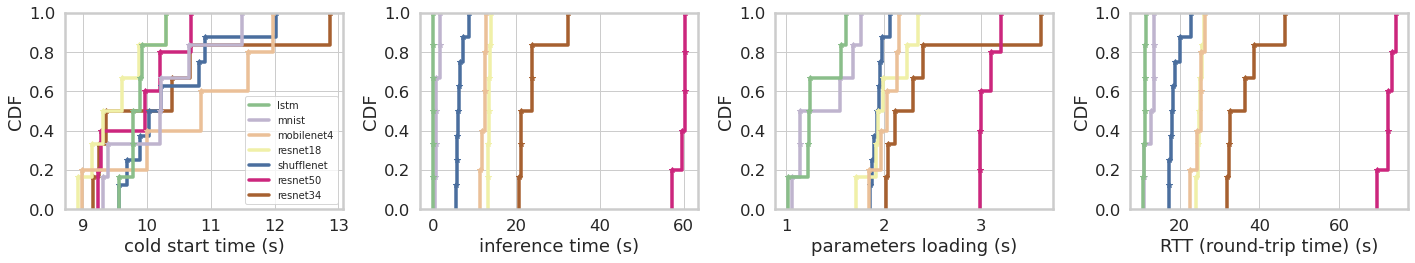

In [8]:
# using seaborn to plot the cdf of coldstart using ecdfplot

def plot_coldstart(df): 
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "axes.linewidth": 2.5,"axes.linestyle":"--"})
    sns.set_palette(colors_for_function)
    fig, axs = plt.subplots(1,4, figsize=(20, 4))
    sns.ecdfplot(data=df, x='coldstart', color=colors_for_function, ax = axs[0], hue ='function',marker='*')
    axs[0].set_xlabel('cold start time (s)')
    axs[0].set_ylabel('CDF')
    # axs[0].set_title('Coldstart')

    sns.ecdfplot(data=df, x='excutionTime', color=colors_for_function, ax = axs[1], hue ='function', legend=False,marker='*')
    # axs[0,1].set_title('Coldstart')
    axs[1].set_xlabel('inference time (s)')
    axs[1].set_ylabel('CDF')

    
    sns.ecdfplot(data=df, x='resp_latency', color=colors_for_function, ax = axs[2], hue ='function', legend=False,marker='*')
    axs[2].set_xlabel('parameters loading (s)')
    axs[2].set_ylabel('CDF')

    sns.ecdfplot(data=df, x='run_time', color=colors_for_function, ax = axs[3], hue ='function',marker='*',legend=False,)

    axs[3].set_xlabel('RTT (round-trip time) (s)')
    axs[3].set_ylabel('CDF')

    sns.move_legend(axs[0], "lower right", ncol=1, frameon=True, fontsize=10,title='')
    
    plt.tight_layout()
    # save the figure
    plt.savefig('figure/coldstart.pdf', bbox_inches='tight', dpi=400)
    plt.show()
plot_coldstart(df_fn_run_plot)

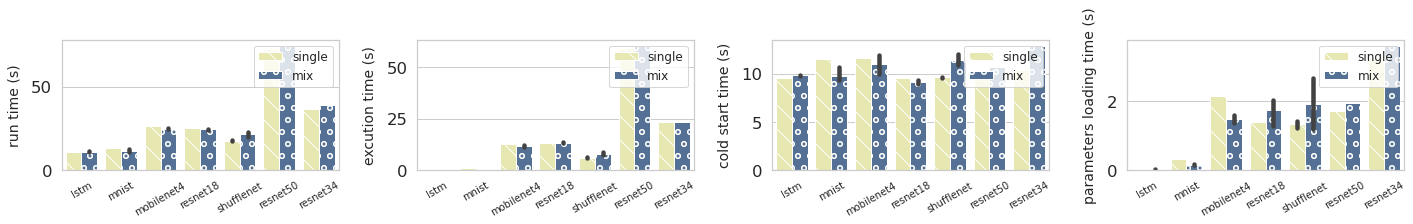

In [53]:
# using seaborn to plot the barplot of run_time

def plot_run_time(df): 
    # hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatches = [ '\\', 'o']

    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_palette(colors_for_function)
    fig, axs = plt.subplots(1,4, figsize=(20, 3))
    # hue style to be hatch pattern
    # sns.barplot(data=df, x='function', y='run_time', hue='type', ax = axs[0], palette=colors_for_function, legend=False)
    f1 = sns.barplot(data=df, x='function', y='run_time', hue='type', ax = axs[0], palette=colors_for_function[3:])
    axs[0].legend()
    axs[0].set_xlabel('')
    axs[0].set_ylabel('run time (s)', fontsize=14, labelpad=10)
    # axs[0].set_title('Coldstart')
    
# Loop over the bars
    for bars, hatch in zip(axs[0].containers, hatches):
    # Set a different hatch for each group of bars
        for bar in bars:
            bar.set_hatch(hatch)
    # create the legend again to show the new hatching


    sns.barplot(data=df, x='function', y='excutionTime', hue='type', ax = axs[1], palette=colors_for_function[3:])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('excution time (s)', fontsize=14, labelpad=10)
    # axs[0,1].set_title('Coldstart')

    sns.barplot(data=df, x='function', y='coldstart', hue='type', ax = axs[2], palette=colors_for_function[3:])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('cold start time (s)', fontsize=14, labelpad=10)



    sns.barplot(data=df, x='function', y='timeModelLoad', hue='type', ax = axs[3], palette=colors_for_function[3:])
    axs[3].set_xlabel('')
    axs[3].set_ylabel('parameters loading time (s)', fontsize=14, labelpad=10)

   

    for ax in axs.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=10)
    
    for ax in axs.flat:
        for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
            for bar in bars:
                bar.set_hatch(hatch)
    # create the legend again to show the new hatching
    

    # set legend of ax[0,1] outside of the plot
    for ax in axs[0:4]:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=12,loc='upper right')
        
    plt.tight_layout()
    # save the figure
    plt.savefig('figure/concurrent.pdf', bbox_inches='tight', dpi=400)
    plt.show()
plot_run_time(df_fn_run_plot_ccr)

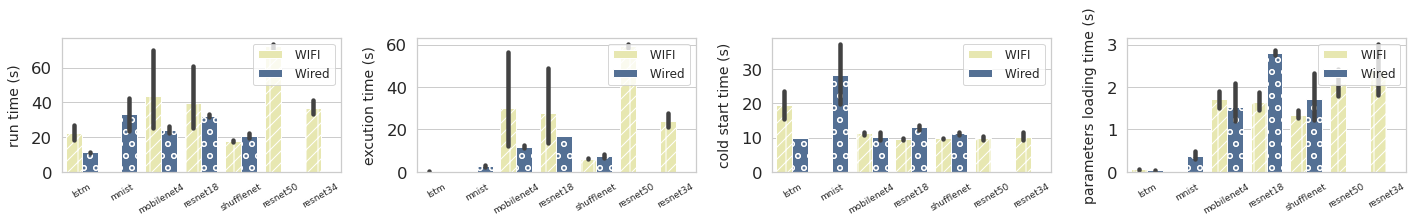

In [54]:

def plot_run_time(df):
    # hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatches = [ '//|', 'o']
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_palette(colors_for_function)
    fig, axs = plt.subplots(1,4, figsize=(20, 3))
    sns.barplot(data=df, x='function', y='run_time', hue='interface', ax = axs[0], palette=colors_for_function[3:])
    axs[0].legend()
    axs[0].set_xlabel('')
    axs[0].set_ylabel('run time (s)', fontsize=14, labelpad=10)
    # axs[0].set_title('Coldstart')



    sns.barplot(data=df, x='function', y='excutionTime', hue='interface', ax = axs[1], palette=colors_for_function[3:])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('excution time (s)', fontsize=14, labelpad=10)
    # axs[0,1].set_title('Coldstart')

    sns.barplot(data=df, x='function', y='coldstart', hue='interface', ax = axs[2], palette=colors_for_function[3:])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('cold start time (s)', fontsize=14, labelpad=10)



    sns.barplot(data=df, x='function', y='timeModelLoad', hue='interface', ax = axs[3], palette=colors_for_function[3:])
    axs[3].set_xlabel('')
    axs[3].set_ylabel('parameters loading time (s)', fontsize=14, labelpad=10)

    

    for ax in axs.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=9)

    # set legend of ax[0,1] outside of the plot
    for ax in axs[0:4]:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=12,loc='upper right')

    # fullfill empty data with white in all axes
    for ax in axs.flat:
        for bars, hatch in zip(ax.containers, hatches):
        # Set a different hatch for each group of bars
            for bar in bars:
                bar.set_hatch(hatch)

    plt.tight_layout()
    # save the figure
    plt.savefig('figure/fn_network.pdf', bbox_inches='tight', dpi=400)
    plt.show()
plot_run_time(df_fn_run)

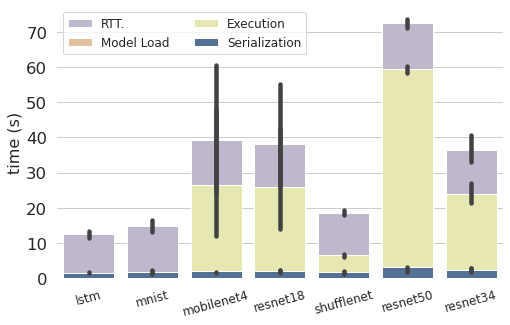

In [58]:
df_fn_run_freq4 = df_fn_run[df_fn_run['freq'] <= 4]
# hatches = ['//','..','xx','*']

f, ax = plt.subplots(figsize=(8, 5))
sns.set_color_codes("pastel")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
# set plot hue by freq
sns.barplot(x="function", y="run_time", data=df_fn_run_freq4,
            label="RTT.", color=colors_for_function[1])
sns.barplot(x="function", y="timeModelLoad", data=df_fn_run_freq4,
            label="Model Load", color=colors_for_function[2])
sns.barplot(x="function", y="excutionTime", data=df_fn_run_freq4,
    label="Execution", color=colors_for_function[3])
sns.barplot(x="function", y="resp_latency", data=df_fn_run_freq4,
            label="Serialization", color=colors_for_function[4])

# for bars, hatch in zip(ax.containers, hatches):
#     # Set a different hatch for each group of bars
#         for bar in bars:
#             bar.set_hatch(hatch)

ax.legend(ncol=2, loc="upper left", frameon=True, fontsize=12)
ax.set_xlabel("")
ax.set_ylabel("time (s)", fontsize=16)
# set the x-axis font size
ax.tick_params(axis='x', labelsize=12)
# rotate the x-axis labels
plt.xticks(rotation=15)
sns.despine(left=True, bottom=True)
plt.savefig('figure/fn_network_freq4.pdf', bbox_inches='tight', dpi=400)

In [10]:
df_fn_run_plot_ccr

,freq,function,invoke_time,timeModelLoad,startTime,endTime,excutionTime,response_time,run_time,ip,type,coldstart,resp_latency,node,interface
0,1,lstm,1.658488e+09,0.040774,1.658488e+09,1.658488e+09,0.065083,1.658488e+09,11.234342,10.244.10.0,single,9.553748,1.615514,euler-30,WIFI
15,1,mnist,1.658489e+09,0.325345,1.658489e+09,1.658489e+09,0.916849,1.658489e+09,13.547668,10.244.15.0,single,11.491495,1.139349,euler-41,Wired
30,1,mobilenet4,1.658489e+09,2.152831,1.658489e+09,1.658489e+09,12.695777,1.658489e+09,26.409496,10.244.8.0,single,11.583041,2.130678,euler-3,WIFI
41,1,resnet18,1.658492e+09,1.405443,1.658492e+09,1.658492e+09,13.219592,1.658492e+09,25.066981,10.244.10.0,single,9.606195,2.241197,euler-30,WIFI
49,1,shufflenet,1.658492e+09,1.434817,1.658492e+09,1.658492e+09,5.774018,1.658492e+09,17.322568,10.244.6.0,single,9.688256,1.860295,euler-13,WIFI
50,1,shufflenet,1.658493e+09,1.233946,1.658493e+09,1.658493e+09,6.345008,1.658493e+09,17.837010,10.244.6.0,single,9.563842,1.928160,euler-13,WIFI
62,1,resnet50,1.658494e+09,1.722211,1.658494e+09,1.658494e+09,59.470219,1.658494e+09,72.421487,10.244.19.0,single,9.966957,2.984313,euler-9,WIFI
66,1,resnet34,1.658499e+09,3.250129,1.658499e+09,1.658499e+09,23.695885,1.658499e+09,36.487797,10.244.9.0,single,10.390280,2.401634,euler-4,WIFI
71,1,lstm,1.658500e+09,0.042342,1.658500e+09,1.658500e+09,0.064366,1.658500e+09,11.414568,10.244.14.0,mix,9.785423,1.564782,euler-37,Wired
72,1,mnist,1.658500e+09,0.143410,1.658500e+09,1.658500e+09,0.625618,1.658500e+09,12.831991,10.244.15.0,mix,10.651649,1.554727,euler-41,Wired


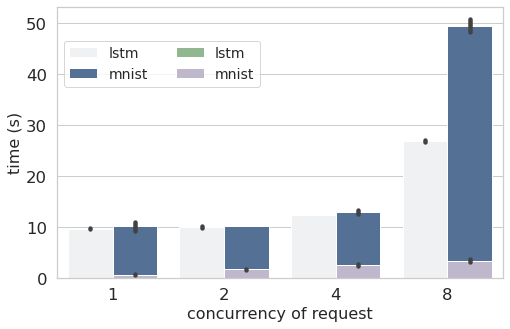

In [50]:
df_fn_run_mnist = df_fn_run[(df_fn_run['function'] == 'mnist') | (df_fn_run['function'] == 'lstm')]
hatches = [ '//|', 'o']

# Plot the orbital period with horizontal boxes
fig, ax = plt.subplots(figsize=(8, 5))
f1= sns.barplot(x="freq", y="coldstart", data=df_fn_run_mnist, hue="function", color=colors_for_function[4], ax =ax)


f2 = sns.barplot(x="freq", y="excutionTime", data=df_fn_run_mnist, hue="function", palette=colors_for_function, ax =ax)
f1.legend(ncol=2, loc="upper left", frameon=True, fontsize=14, bbox_to_anchor=(0, .9))
ax.set_xlabel("concurrency of request", fontsize=16)
ax.set_ylabel("time (s)", fontsize=16)


plt.savefig('figure/fn_network_mnist.pdf', bbox_inches='tight', dpi=400)